Predicting the Weather with Neural Networks
===========================================


Example neural network

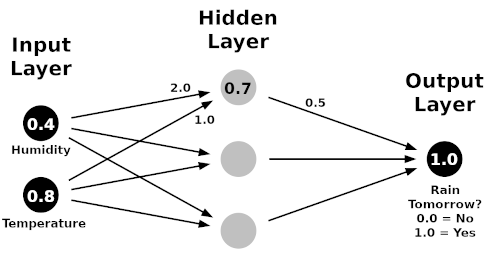

Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

Read a CSV data file.

In [4]:
df = pd.read_csv("weatherPerth.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-07-01,Perth,2.7,18.8,0.0,0.8,9.1,ENE,20.0,NaN,...,53.0,1027.6,1024.5,2.0,3.0,8.5,18.1,No,0.0,No
1,2008-07-02,Perth,6.4,20.7,0.0,1.8,7.0,NE,22.0,ESE,...,39.0,1024.1,1019.0,0.0,6.0,11.1,19.7,No,0.4,No
2,2008-07-03,Perth,6.5,19.9,0.4,2.2,7.3,NE,31.0,NaN,...,71.0,1016.8,1015.6,1.0,3.0,12.1,17.7,No,1.8,Yes
3,2008-07-04,Perth,9.5,19.2,1.8,1.2,4.7,W,26.0,NNE,...,73.0,1019.3,1018.4,6.0,6.0,13.2,17.7,Yes,1.8,Yes
4,2008-07-05,Perth,9.5,16.4,1.8,1.4,4.9,WSW,44.0,W,...,57.0,1020.4,1022.1,7.0,5.0,15.9,16.0,Yes,6.8,Yes


Pre-process the data.  First, remove unwanted variables.

In [5]:
exclude = ['Date', 'RISK_MM', 'Location']
for var in exclude:
    del df[var]

Dealing with missing values.

In [6]:
df = df.dropna()

Boolean variables to 0s and 1s.

In [7]:
bools = ['RainToday', 'RainTomorrow']
for var in bools:
    df[var] = df[var].map({
        'Yes': 1,
        'No': 0
    })
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
1,6.4,20.7,0.0,1.8,7.0,NE,22.0,ESE,ENE,6,...,80.0,39.0,1024.1,1019.0,0.0,6.0,11.1,19.7,0,0
3,9.5,19.2,1.8,1.2,4.7,W,26.0,NNE,NNW,11,...,93.0,73.0,1019.3,1018.4,6.0,6.0,13.2,17.7,1,1
4,9.5,16.4,1.8,1.4,4.9,WSW,44.0,W,SW,13,...,69.0,57.0,1020.4,1022.1,7.0,5.0,15.9,16.0,1,1
5,0.7,15.9,6.8,2.4,9.3,NNE,24.0,ENE,NE,4,...,86.0,41.0,1032.0,1029.6,0.0,1.0,6.9,15.5,1,0
6,0.7,18.3,0.0,0.8,9.3,N,37.0,NE,NNE,15,...,72.0,36.0,1028.9,1024.2,1.0,5.0,8.7,17.9,0,0


Cyclical attributes

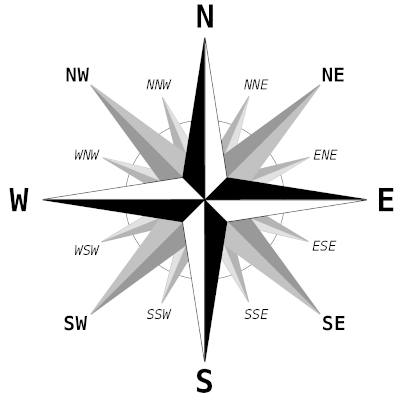

In [8]:
wind_attributes = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# Cardinal direction to radians
dirs = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
angles = np.arange(0.0, 2.0*np.pi, 2.0*np.pi / 16.0)
wind_angles = dict(zip(dirs, angles))
print(wind_angles)

for var in wind_attributes:
    df[var] = df[var].map(wind_angles)
    df[var + '_cos'] = np.cos(df[var])
    df[var + '_sin'] = np.sin(df[var])
    df = df.drop(columns=var)
df.head()

{'N': 0.0, 'NNE': 0.39269908169872414, 'NE': 0.7853981633974483, 'ENE': 1.1780972450961724, 'E': 1.5707963267948966, 'ESE': 1.9634954084936207, 'SE': 2.356194490192345, 'SSE': 2.748893571891069, 'S': 3.141592653589793, 'SSW': 3.5342917352885173, 'SW': 3.9269908169872414, 'WSW': 4.319689898685965, 'W': 4.71238898038469, 'WNW': 5.105088062083414, 'NW': 5.497787143782138, 'NNW': 5.890486225480862}


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_cos,WindGustDir_sin,WindDir9am_cos,WindDir9am_sin,WindDir3pm_cos,WindDir3pm_sin
1,6.4,20.7,0.0,1.8,7.0,22.0,6,9.0,80.0,39.0,...,11.1,19.7,0,0,7.071068e-01,0.707107,-3.826834e-01,0.923880,0.382683,0.923880
3,9.5,19.2,1.8,1.2,4.7,26.0,11,6.0,93.0,73.0,...,13.2,17.7,1,1,-1.836970e-16,-1.000000,9.238795e-01,0.382683,0.923880,-0.382683
4,9.5,16.4,1.8,1.4,4.9,44.0,13,17.0,69.0,57.0,...,15.9,16.0,1,1,-3.826834e-01,-0.923880,-1.836970e-16,-1.000000,-0.707107,-0.707107
5,0.7,15.9,6.8,2.4,9.3,24.0,4,7.0,86.0,41.0,...,6.9,15.5,1,0,9.238795e-01,0.382683,3.826834e-01,0.923880,0.707107,0.707107
6,0.7,18.3,0.0,0.8,9.3,37.0,15,13.0,72.0,36.0,...,8.7,17.9,0,0,1.000000e+00,0.000000,7.071068e-01,0.707107,0.923880,0.382683


Extract attributes (X) and class labels (y).

In [9]:
y = df["RainTomorrow"]
X = df.drop(columns="RainTomorrow")

Split dataset into training and testing subsets.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.33,
    random_state=0
)
print('X_train', X_train.shape)
print('X_test', X_test.shape)

X_train (2026, 23)
X_test (999, 23)


Scale.

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Input layer size.

In [12]:
print(X_train.shape)

(2026, 23)


In [13]:
classifier = MLPClassifier(
    hidden_layer_sizes=(50,50),
    max_iter=500,
    random_state=0
)
classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=0)

Predict target class for the testing set.

In [14]:
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8928928928928929


Search for best network layout.

In [36]:
parameters = {
    'hidden_layer_sizes': (
        (2,), (10,), (50,50),
    )
}
nn = MLPClassifier(max_iter=2000, random_state=0)
gridsearch = GridSearchCV(nn, parameters, cv=3)
gridsearch.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=2000, random_state=0),
             param_grid={'hidden_layer_sizes': ((2,), (10,), (50, 50))})

Display grid search results.

In [37]:
print(gridsearch.cv_results_['params'])
print(gridsearch.cv_results_['mean_test_score'])

[{'hidden_layer_sizes': (2,)}, {'hidden_layer_sizes': (10,)}, {'hidden_layer_sizes': (50, 50)}]
[0.90424355 0.89487179 0.88450873]


Predictions using the best neural network.

In [38]:
best_nn = gridsearch.best_estimator_
y_pred = best_nn.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8938938938938938
